# Import Libraries

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from datetime import datetime, timedelta

import folium
from folium.plugins import HeatMap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

import joblib

# Generate Functions

In [110]:
def generate_heatmap(df, target_date):
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Filter data for the specific target date
    df_filtered = df[df['timestamp'].dt.date == pd.to_datetime(target_date).date()]

    # Check if there are records for the specified date
    if df_filtered.empty:
        print(f"No data available for {target_date}")
        return None

    # Extract latitude, longitude, and taxi_count
    taxi_locations = df_filtered[['latitude', 'longitude', 'taxi_count']]

    # Initialize the map, centered on Singapore's coordinates
    singapore_map = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

    # Prepare data for HeatMap: each point is a list [latitude, longitude, weight (taxi_count)]
    heatmap_data = taxi_locations[['latitude', 'longitude', 'taxi_count']].values.tolist()

    # Set the maximum taxi count to adjust the intensity scale (so that the highest taxi count is red)
    max_taxi_count = df_filtered['taxi_count'].max()

    # Add HeatMap layer to the map with higher blur and ensuring the intensity is proportional to taxi_count
    HeatMap(heatmap_data, 
            radius=10,  # Control the spread of each point
            blur=15,    # Controls the blur to make it smoother
            min_opacity=0.6,  # Ensure even low-density areas are visible
            max_val=max_taxi_count,  # Set the maximum intensity
            gradient={0.2: 'blue', 0.4: 'green', 0.7: 'yellow', 1: 'red'}  # Color gradient mapping for intensity
           ).add_to(singapore_map)

    # Return the heatmap
    return singapore_map

# Define Parameters

In [111]:
# Define the API endpoint
URL = "https://api.data.gov.sg/v1/transport/taxi-availability"

# Create a list of timestamps for the past 30 days (hourly intervals)
current_date = datetime.now()
start_date = (current_date - timedelta(days=31)).replace(hour=0, minute=59, second=0, microsecond=0)

# Generate a list of timestamps at hourly intervals
timestamps = pd.date_range(start=start_date, end=current_date, freq='H')

/var/folders/j5/m90b2sqx6k9dr4l9ys0fgx300000gn/T/ipykernel_14333/3977842624.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=start_date, end=current_date, freq='H')


# Data Retrieval via API

### Taxi Availability (Hourly)

In [112]:
# # List to store the data
# taxi_data = []

# # Loop through each timestamp and retrieve data
# for timestamp in timestamps:
#     # Convert the timestamp to the required format
#     date_time_str = timestamp.strftime('%Y-%m-%dT%H:%M:%S')

#     # Define parameters for the API request
#     params = {
#         "date_time": date_time_str
#     }

#     # Send the GET request
#     response = requests.get(URL, params=params)

#     # Check if the request was successful
#     if response.status_code == 200:
#         data = response.json()
#         features = data["features"]
        
#         for feature in features:
#             coordinates = feature["geometry"]["coordinates"]
#             taxi_count = feature["properties"]["taxi_count"]
#             request_time = feature["properties"]["timestamp"]

#             for coordinate in coordinates:
#                 taxi_data.append({
#                     "timestamp": request_time,
#                     "taxi_count": taxi_count,
#                     "longitude": coordinate[0],
#                     "latitude": coordinate[1]
#                 })
#     else:
#         print(f"Failed to retrieve data for {date_time_str}. Status code: {response.status_code}")

# # Convert the list to a DataFrame
# df = pd.DataFrame(taxi_data)

# # Save the data to CSV for further analysis
# df.to_csv('taxi_availability_last_31_days.csv', index=False)

# # Display a sample of the data
# print(df.head())

### 2-Hourly Weather Forecast

In [113]:
# # DataFrame to store all forecast data for 31 days
# weather_list = []

# # Loop through each timestamp
# for timestamp in timestamps:
#     formatted_date = timestamp.strftime('%Y-%m-%dT%H:%M:%S')
#     forecast_url = f"https://api-open.data.gov.sg/v2/real-time/api/two-hr-forecast?date={formatted_date}"
#     response = requests.get(forecast_url)

#     if response.status_code == 200:
#         forecast_data = response.json()
#         area_metadata = forecast_data['data']['area_metadata']
#         forecast_items = forecast_data['data']['items']

#         # Extract data including valid period
#         for forecast_item in forecast_items:
#             valid_period_start = pd.to_datetime(forecast_item['valid_period']['start'])
#             valid_period_end = pd.to_datetime(forecast_item['valid_period']['end'])
#             forecasts = forecast_item['forecasts']
            
#             for forecast in forecasts:
#                 for area in area_metadata:
#                     if area['name'] == forecast['area']:
#                         weather_list.append({
#                             'timestamp': timestamp,
#                             'area': area['name'],
#                             'latitude': area['label_location']['latitude'],
#                             'longitude': area['label_location']['longitude'],
#                             'forecast': forecast['forecast'],
#                             'valid_period_start': valid_period_start,
#                             'valid_period_end': valid_period_end
#                         })

# # Create DataFrame for weather data
# weather_df = pd.DataFrame(weather_list)

# # Save the data to CSV for further analysis
# weather_df.to_csv('2h-weather-forecast.csv', index=False)

# print(weather_df.head())


### Real-time Rainfall Data

In [114]:
# # DataFrame to store all rainfall data for 31 days
# rainfall_list = []

# # Loop through each timestamp
# for timestamp in timestamps:
#     formatted_date = timestamp.strftime('%Y-%m-%dT%H:%M:%S')
#     rainfall_url = f"https://api-open.data.gov.sg/v2/real-time/api/rainfall?date={formatted_date}"
#     response = requests.get(rainfall_url)

#     if response.status_code == 200:
#         rainfall_data = response.json()
#         stations = rainfall_data['data']['stations']
#         readings = rainfall_data['data']['readings']

#         # Extract data with timestamp
#         for reading_item in readings:
#             reading_timestamp = pd.to_datetime(reading_item['timestamp'])
#             reading_data = reading_item['data']
            
#             for station in stations:
#                 for reading in reading_data:
#                     if station['id'] == reading['stationId']:
#                         rainfall_list.append({
#                             'timestamp': timestamp,
#                             'station': station['name'],
#                             'latitude': station['location']['latitude'],
#                             'longitude': station['location']['longitude'],
#                             'rainfall': reading['value']
#                         })

# # Create DataFrame for rainfall data
# rainfall_df = pd.DataFrame(rainfall_list)

# # Save the data to CSV for further analysis
# rainfall_df.to_csv('real-time-rainfall.csv', index=False)

# print(rainfall_df.head())


# Load Dataset

In [115]:
taxi_df = pd.read_csv('taxi_availability_last_31_days.csv')
print(taxi_df.head(), '\n')
print(taxi_df.info())

                   timestamp  taxi_count  longitude  latitude
0  2024-09-21T00:58:50+08:00        1925  103.61425   1.25835
1  2024-09-21T00:58:50+08:00        1925  103.61440   1.24648
2  2024-09-21T00:58:50+08:00        1925  103.62625   1.31000
3  2024-09-21T00:58:50+08:00        1925  103.63298   1.29769
4  2024-09-21T00:58:50+08:00        1925  103.63696   1.34066 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548939 entries, 0 to 1548938
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   timestamp   1548939 non-null  object 
 1   taxi_count  1548939 non-null  int64  
 2   longitude   1548939 non-null  float64
 3   latitude    1548939 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 47.3+ MB
None


# Heat Map

<Axes: xlabel='longitude', ylabel='latitude'>

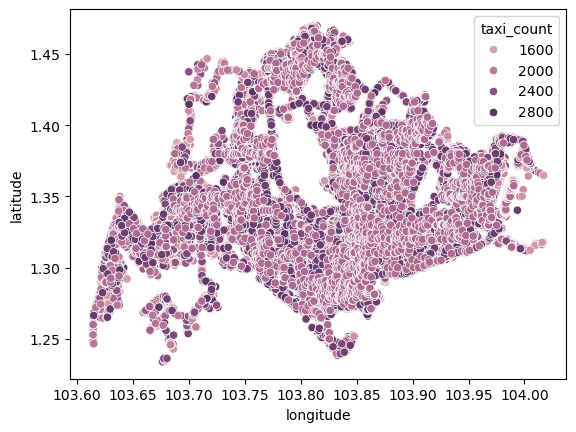

In [116]:
sns.scatterplot(data = taxi_df, x = 'longitude', y='latitude', hue='taxi_count')

# Location Clustering with KMeans

In [117]:
# Extracting longitude and latitude
location_data = taxi_df[['longitude', 'latitude']].values

### Elbow Method
-  Within-cluster sum of squares (WCSS): Sum of square distances between the centroids and each points
-  To determine the optimal number of clusters, we have to select the value of k at the “elbow” i.e., the point after which the distortion/inertia starts decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 4.

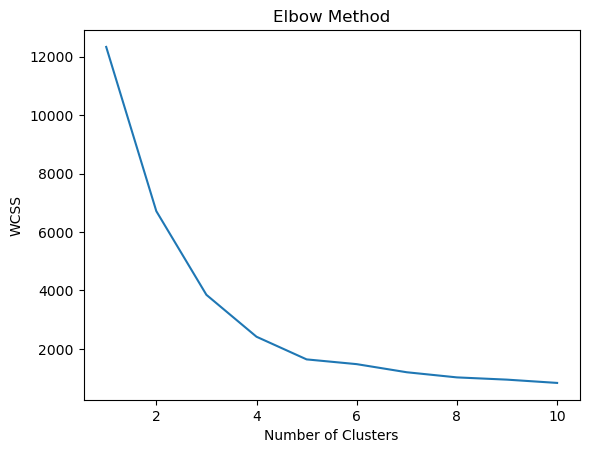

In [118]:
# Choosing an optimal number of clusters from a range between 1 and 10 using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(location_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

### Train data using the optimal number of clusters

In [119]:
optimal_k = 5
kmeans = KMeans(n_clusters = optimal_k, init = 'k-means++', random_state = 42)
taxi_df['cluster_id'] = kmeans.fit_predict(location_data)

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


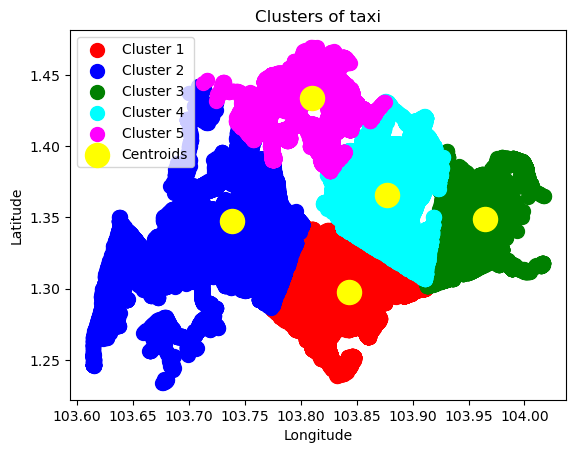

In [120]:
y_kmeans = taxi_df['cluster_id']
plt.scatter(location_data[y_kmeans == 0, 0], location_data[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(location_data[y_kmeans == 1, 0], location_data[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(location_data[y_kmeans == 2, 0], location_data[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(location_data[y_kmeans == 3, 0], location_data[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(location_data[y_kmeans == 4, 0], location_data[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of taxi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [121]:
taxi_df

,timestamp,taxi_count,longitude,latitude,cluster_id
0,2024-09-21T00:58:50+08:00,1925,103.614250,1.258350,1
1,2024-09-21T00:58:50+08:00,1925,103.614400,1.246480,1
2,2024-09-21T00:58:50+08:00,1925,103.626250,1.310000,1
3,2024-09-21T00:58:50+08:00,1925,103.632980,1.297690,1
4,2024-09-21T00:58:50+08:00,1925,103.636960,1.340660,1
...,...,...,...,...,...
1548934,2024-10-22T13:58:49+08:00,2141,103.990453,1.357518,2
1548935,2024-10-22T13:58:49+08:00,2141,103.997040,1.379304,2
1548936,2024-10-22T13:58:49+08:00,2141,103.999520,1.385930,2
1548937,2024-10-22T13:58:49+08:00,2141,104.001220,1.378140,2


In [122]:
# Extract cluster centers
cluster_centers = kmeans.cluster_centers_
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['longitude', 'latitude'])
cluster_centers_df['cluster_id'] = range(optimal_k)
cluster_centers_df.to_csv('cluster_centers.csv', index=False)
print(cluster_centers_df.head())

    longitude  latitude  cluster_id
0  103.843131  1.297685           0
1  103.738607  1.347152           1
2  103.965013  1.349019           2
3  103.876638  1.365980           3
4  103.810107  1.433685           4


# Create Aggregated Data by Cluster

In [123]:
# Convert timestamp to datetime and extract relevant time features
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df['hour'] = taxi_df['timestamp'].dt.hour
taxi_df['date'] = taxi_df['timestamp'].dt.date
taxi_df['day_of_week'] = taxi_df['timestamp'].dt.weekday
# taxi_df_encoded = pd.get_dummies(taxi_df, columns=['day_of_week'], prefix='day', dtype=int)
# taxi_df_encoded = pd.get_dummies(taxi_df, columns=['cluster_id'], prefix='cluster', dtype=int)

# taxi_df_encoded
# # Group by timestamp and cluster_id to calculate the hourly number of taxis per cluster
# cluster_data = taxi_df_encoded.groupby(['date', 'hour', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'cluster_id']).size().reset_index(name='num_taxis_available')
cluster_data = taxi_df.groupby(['date', 'hour', 'day_of_week', 'cluster_id']).size().reset_index(name='num_taxis_available')

In [124]:
cluster_data

,date,hour,day_of_week,cluster_id,num_taxis_available
0,2024-09-21,0,5,0,423
1,2024-09-21,0,5,1,362
2,2024-09-21,0,5,2,436
3,2024-09-21,0,5,3,435
4,2024-09-21,0,5,4,269
...,...,...,...,...,...
3785,2024-10-22,13,1,0,544
3786,2024-10-22,13,1,1,389
3787,2024-10-22,13,1,2,503
3788,2024-10-22,13,1,3,472


In [125]:
print('Timestamp (hour): ', cluster_data['hour'].unique().tolist())
print('Cluster ID: ', cluster_data['cluster_id'].unique().tolist())

Timestamp (hour):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Cluster ID:  [0, 1, 2, 3, 4]


In [126]:
cluster_data

,date,hour,day_of_week,cluster_id,num_taxis_available
0,2024-09-21,0,5,0,423
1,2024-09-21,0,5,1,362
2,2024-09-21,0,5,2,436
3,2024-09-21,0,5,3,435
4,2024-09-21,0,5,4,269
...,...,...,...,...,...
3785,2024-10-22,13,1,0,544
3786,2024-10-22,13,1,1,389
3787,2024-10-22,13,1,2,503
3788,2024-10-22,13,1,3,472


# Feature Engineering

## Create Lag Features

In [127]:
# Create lag features
lags = [1, 2, 3, 24]  # Lag of 1 hour, 2 hours, 3 hours
for lag in lags:
    cluster_data[f'lag_{lag}'] = cluster_data.groupby('cluster_id')['num_taxis_available'].shift(lag)

In [128]:
# cluster_data[cluster_data['date'] > datetime.strptime('2024-09-21', '%Y-%m-%d').date()]

In [129]:
print('Null values for the past 31 days:\n\n', cluster_data.isnull().sum())

Null values for the past 31 days:

 date                     0
hour                     0
day_of_week              0
cluster_id               0
num_taxis_available      0
lag_1                    5
lag_2                   10
lag_3                   15
lag_24                 120
dtype: int64


## Dropping First Date (due to null values)

In [130]:
first_date = cluster_data['date'].min()
cluster_data_filtered = cluster_data[cluster_data['date'] > first_date].reset_index(drop=True)

In [131]:
cluster_data_filtered.head(20)

,date,hour,day_of_week,cluster_id,num_taxis_available,lag_1,lag_2,lag_3,lag_24
0,2024-09-22,0,6,0,506,586.0,550.0,653.0,423.0
1,2024-09-22,0,6,1,265,291.0,294.0,270.0,362.0
2,2024-09-22,0,6,2,302,357.0,522.0,557.0,436.0
3,2024-09-22,0,6,3,328,424.0,443.0,431.0,435.0
4,2024-09-22,0,6,4,162,213.0,236.0,237.0,269.0
5,2024-09-22,1,6,0,527,506.0,586.0,550.0,423.0
6,2024-09-22,1,6,1,328,265.0,291.0,294.0,331.0
7,2024-09-22,1,6,2,358,302.0,357.0,522.0,268.0
8,2024-09-22,1,6,3,482,328.0,424.0,443.0,459.0
9,2024-09-22,1,6,4,244,162.0,213.0,236.0,256.0


In [132]:
print('Null values for the past 30 days:\n\n', cluster_data_filtered.isnull().sum())

Null values for the past 30 days:

 date                   0
hour                   0
day_of_week            0
cluster_id             0
num_taxis_available    0
lag_1                  0
lag_2                  0
lag_3                  0
lag_24                 0
dtype: int64


#

# Modelling - Define Parameters

In [133]:
# Features and target variable
features = ['lag_1', 'lag_2', 'lag_3', 'lag_24', 'day_of_week', 'cluster_id']

X = cluster_data_filtered[features]
y = cluster_data_filtered['num_taxis_available']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling - Define Functions

In [134]:
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2
    }

# Benchmark: Linear Regression

In [135]:
# Standardization for Linear Regression
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_scaled)

# Random Forest Regressor

In [136]:
# Initialize and train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Gradient Boosting Regressor

In [137]:
# Initialize and train Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gbr = gbr_model.predict(X_test)

# XGBoost Regressor

In [138]:
# Initialize and train XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Model Performance: Evaluation

In [139]:
# Initialize an empty list to store evaluation metrics for all models
evaluation_results = []

# Evaluate Linear Regression
evaluation_results.append(evaluate_model(y_test, y_pred_lr, "Linear Regression"))

# Evaluate Random Forest Regressor
evaluation_results.append(evaluate_model(y_test, y_pred_rf, "Random Forest Regressor"))

# Evaluate Gradient Boosting Regressor
evaluation_results.append(evaluate_model(y_test, y_pred_gbr, "Gradient Boosting Regressor"))

# Evaluate XGBoost Regressor
evaluation_results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor"))

In [140]:
# Create a DataFrame from the list of evaluation results
performance_df = pd.DataFrame(evaluation_results)

# Display the DataFrame
print(performance_df)

                         Model        MAE      RMSE  R-squared
0            Linear Regression  45.086073  7.858261   0.855660
1      Random Forest Regressor  44.462956  7.829725   0.857745
2  Gradient Boosting Regressor  44.111405  7.769093   0.862101
3            XGBoost Regressor  46.223871  7.945374   0.849153


# Hyperparameter Tuning

### Define Function

In [141]:
def hyperparameter_tuning(model, param_grid, X_train, y_train, model_name):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=2
    )
    # Fit the model to the training data
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}:", grid_search.best_params_)
    return grid_search.best_estimator_

### Random Forest Regressor

In [142]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_model = RandomForestRegressor(random_state=42)
best_rf_model = hyperparameter_tuning(rf_model, rf_param_grid, X_train, y_train, "Random Forest Regressor")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
155 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-p

Best parameters for Random Forest Regressor: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Gradient Boosting Regressor

In [143]:
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}
gb_model = GradientBoostingRegressor(random_state=42)
best_gb_model = hyperparameter_tuning(gb_model, gb_param_grid, X_train, y_train, "Gradient Boosting Regressor")

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.

### XGBoost Regressor

In [144]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBRegressor(random_state=42)
best_xgb_model = hyperparameter_tuning(xgb_model, xgb_param_grid, X_train, y_train, "XGBoost Regressor")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsam

In [145]:
# Evaluate all models
y_pred_best_rf = best_rf_model.predict(X_test)
y_pred_best_gb = best_gb_model.predict(X_test)
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluate Random Forest, Gradient Boosting, and XGBoost
evaluation_results.append(evaluate_model(y_test, y_pred_best_rf, "Tuned Random Forest Regressor"))
evaluation_results.append(evaluate_model(y_test, y_pred_best_gb, "Tuned Gradient Boosting Regressor"))
evaluation_results.append(evaluate_model(y_test, y_pred_best_xgb, "Tuned XGBoost Regressor"))

# Evaluation of All Models

### Performance Metrics

In [146]:
# List of models and predictions
model_names = [
    "Linear Regression",
    "Random Forest Regressor",
    "Gradient Boosting Regressor",
    "XGBoost Regressor",
    "Tuned Random Forest Regressor",
    "Tuned Gradient Boosting Regressor",
    "Tuned XGBoost Regressor"
]

predictions = [
    y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_xgb, 
    y_pred_best_rf, y_pred_best_gb, y_pred_best_xgb
]

In [147]:
# Create a DataFrame from the list of evaluation results
performance_df = pd.DataFrame(evaluation_results)

# Display the DataFrame
print(performance_df)

                               Model        MAE      RMSE  R-squared
0                  Linear Regression  45.086073  7.858261   0.855660
1            Random Forest Regressor  44.462956  7.829725   0.857745
2        Gradient Boosting Regressor  44.111405  7.769093   0.862101
3                  XGBoost Regressor  46.223871  7.945374   0.849153
4      Tuned Random Forest Regressor  43.087881  7.695190   0.867273
5  Tuned Gradient Boosting Regressor  43.180981  7.715688   0.865854
6            Tuned XGBoost Regressor  42.822787  7.649221   0.870417


### Visualization: Actual vs Predicted
-  The dashed line represents perfect predictions, and points close to this line indicate better predictions.

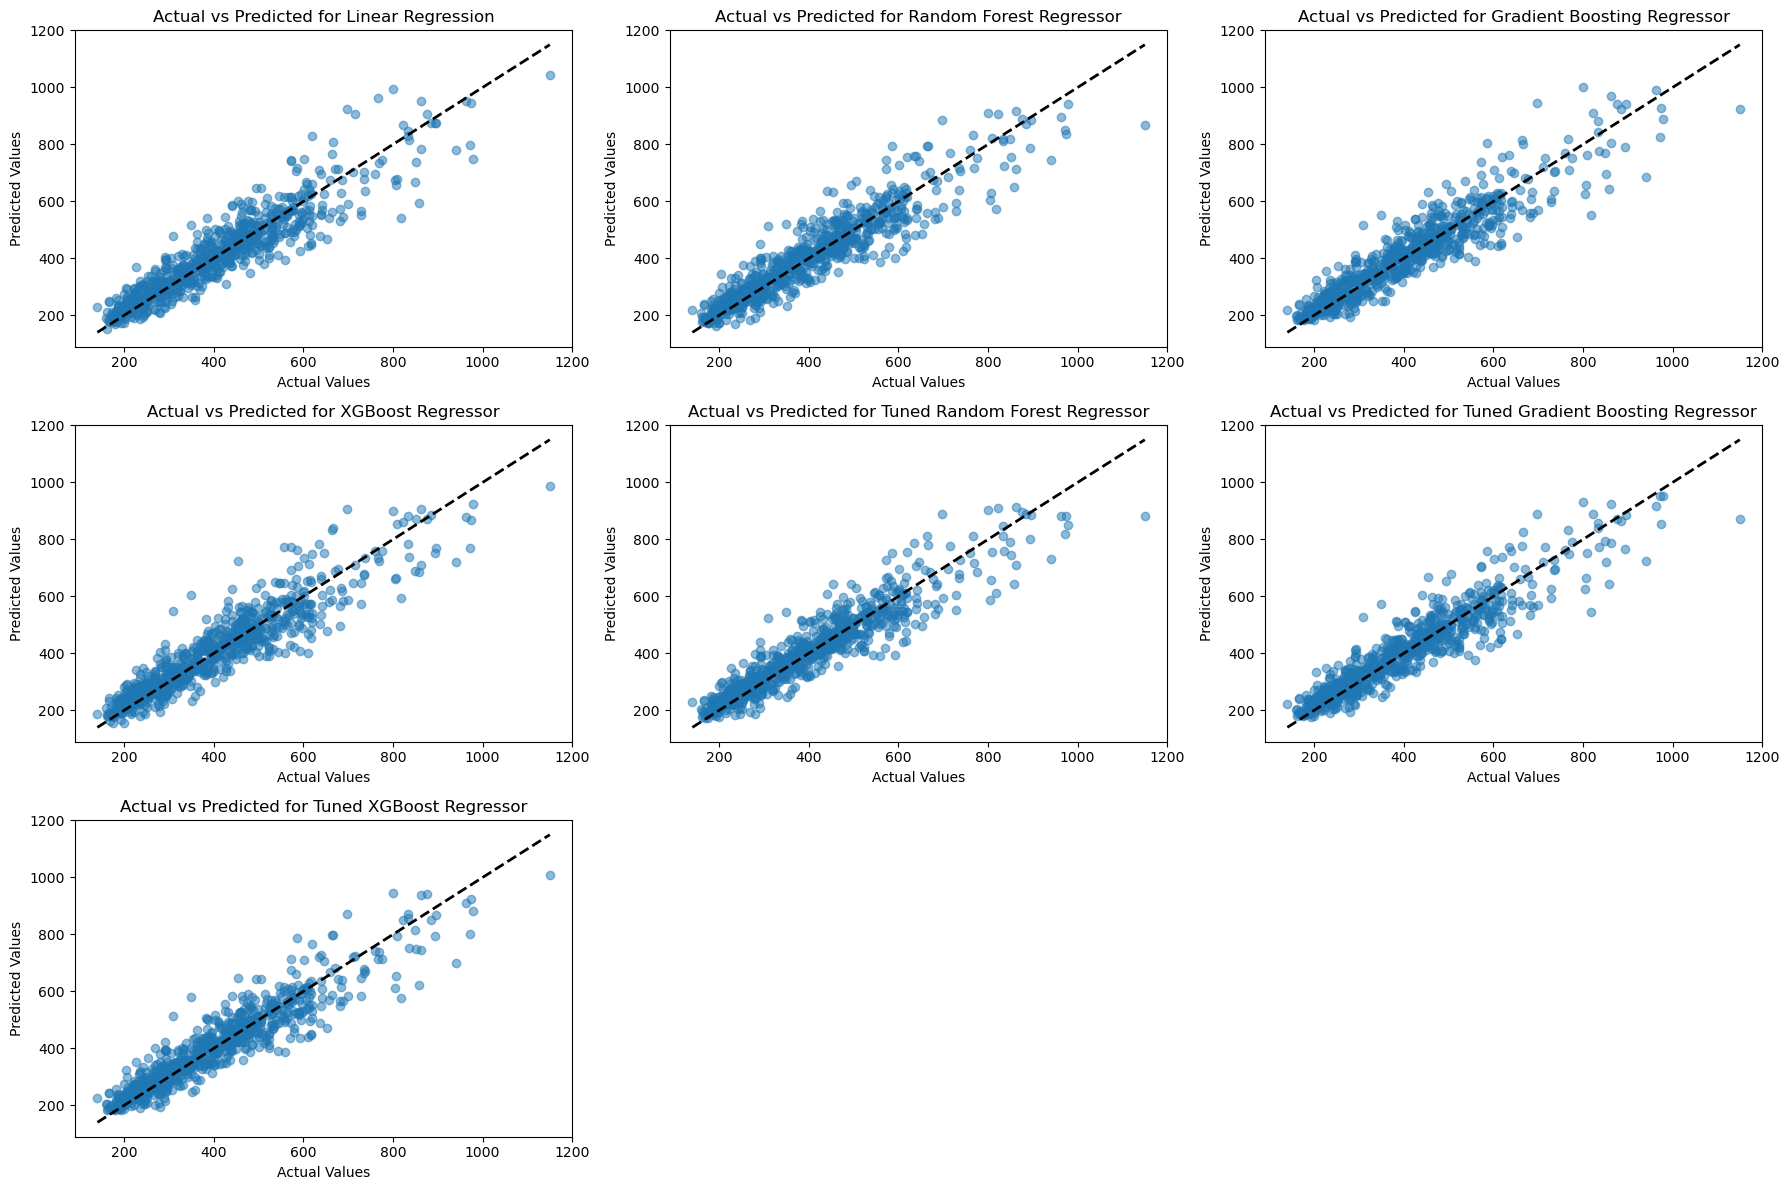

In [148]:
# Plot Actual vs Predicted for each model
def plot_actual_vs_predicted(y_test, predictions, model_names):
    plt.figure(figsize=(18, 12))
    for i, (y_pred, model_name) in enumerate(zip(predictions, model_names)):
        plt.subplot(3, 3, i + 1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted for {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, predictions, model_names)

### Visualization: Residual Plot
-  Ideally, the residuals should be randomly distributed around zero, without any obvious patterns. If there's a systematic pattern, it may indicate model bias or non-linearity.

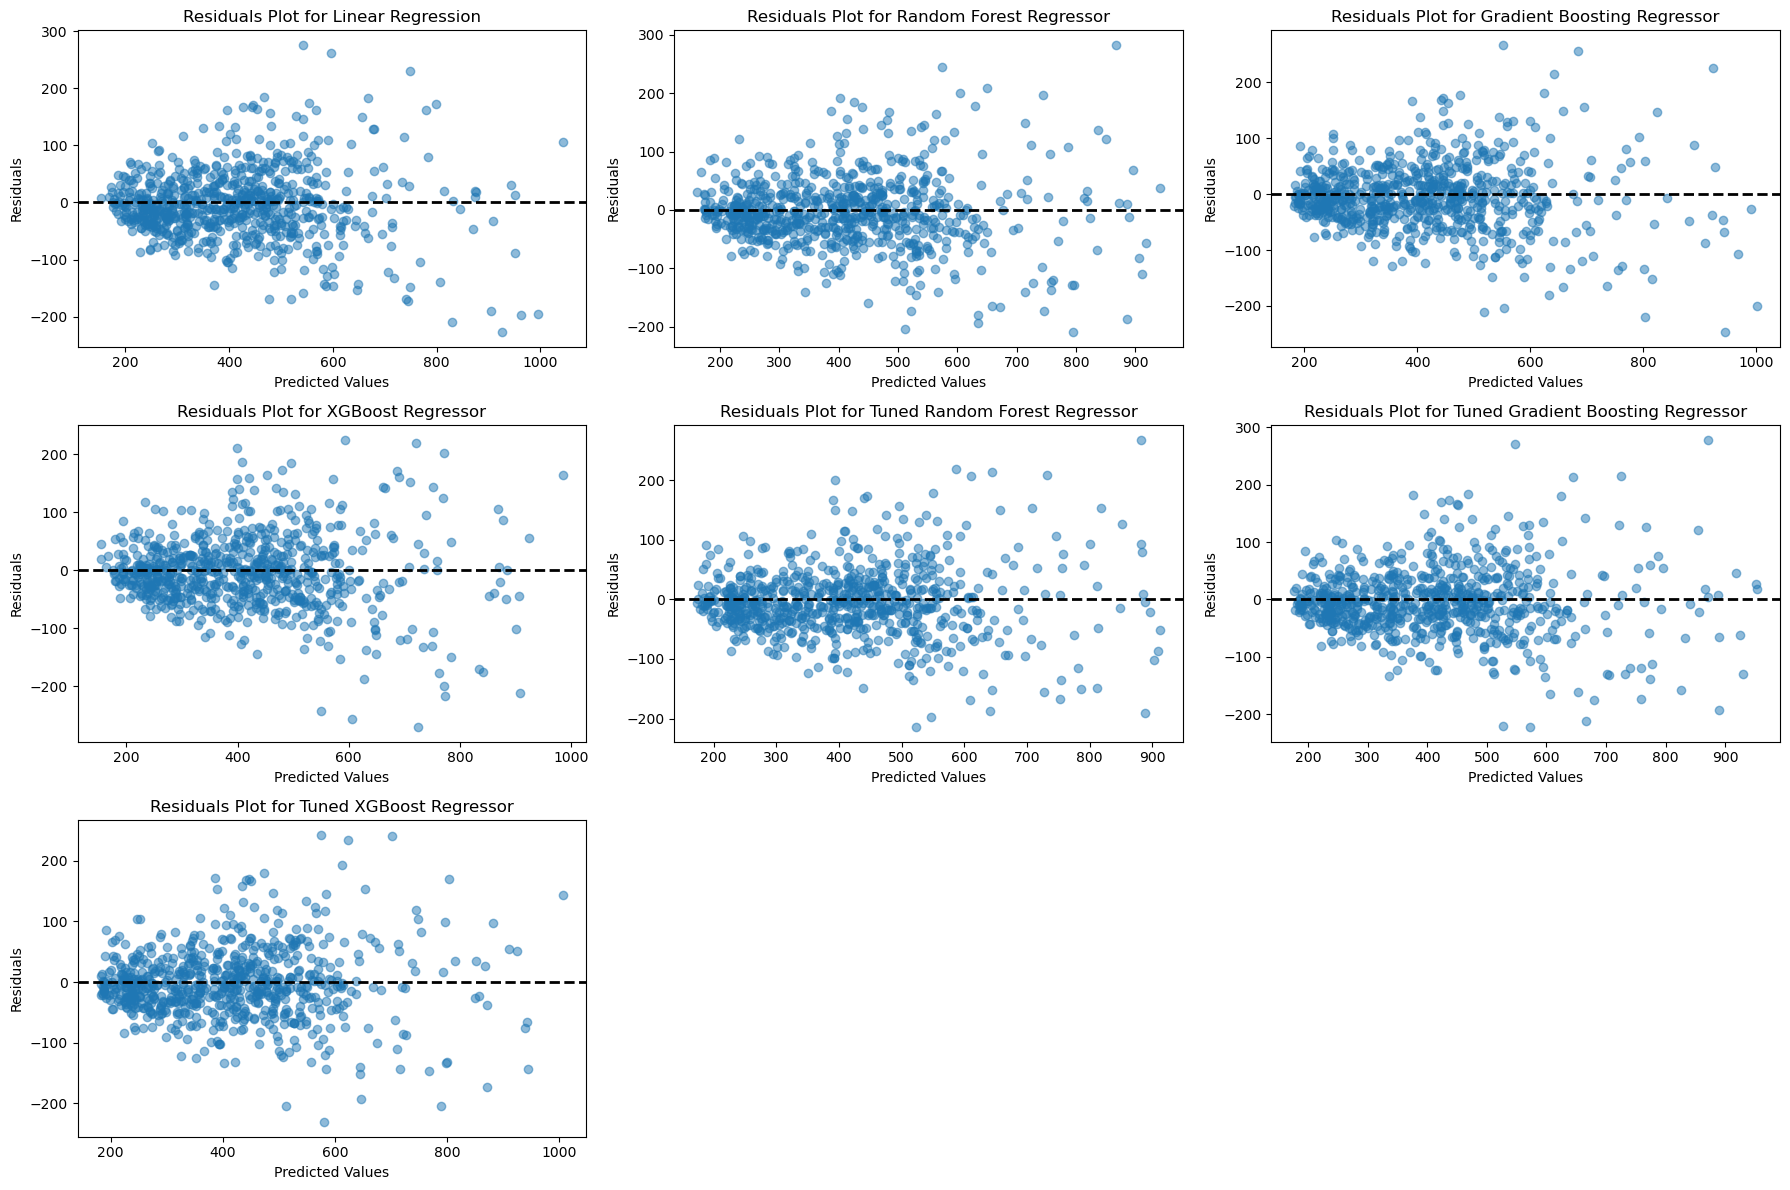

In [149]:
# Plot Residuals for each model
def plot_residuals(y_test, predictions, model_names):
    plt.figure(figsize=(18, 12))
    for i, (y_pred, model_name) in enumerate(zip(predictions, model_names)):
        residuals = y_test - y_pred
        plt.subplot(3, 3, i + 1)
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(0, color='k', linestyle='--', lw=2)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals Plot for {model_name}')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, predictions, model_names)

### Visualization: Error Distribution Plot
-  A normal distribution centered around zero indicates that the model has a good fit, with no major systematic error in predictions.

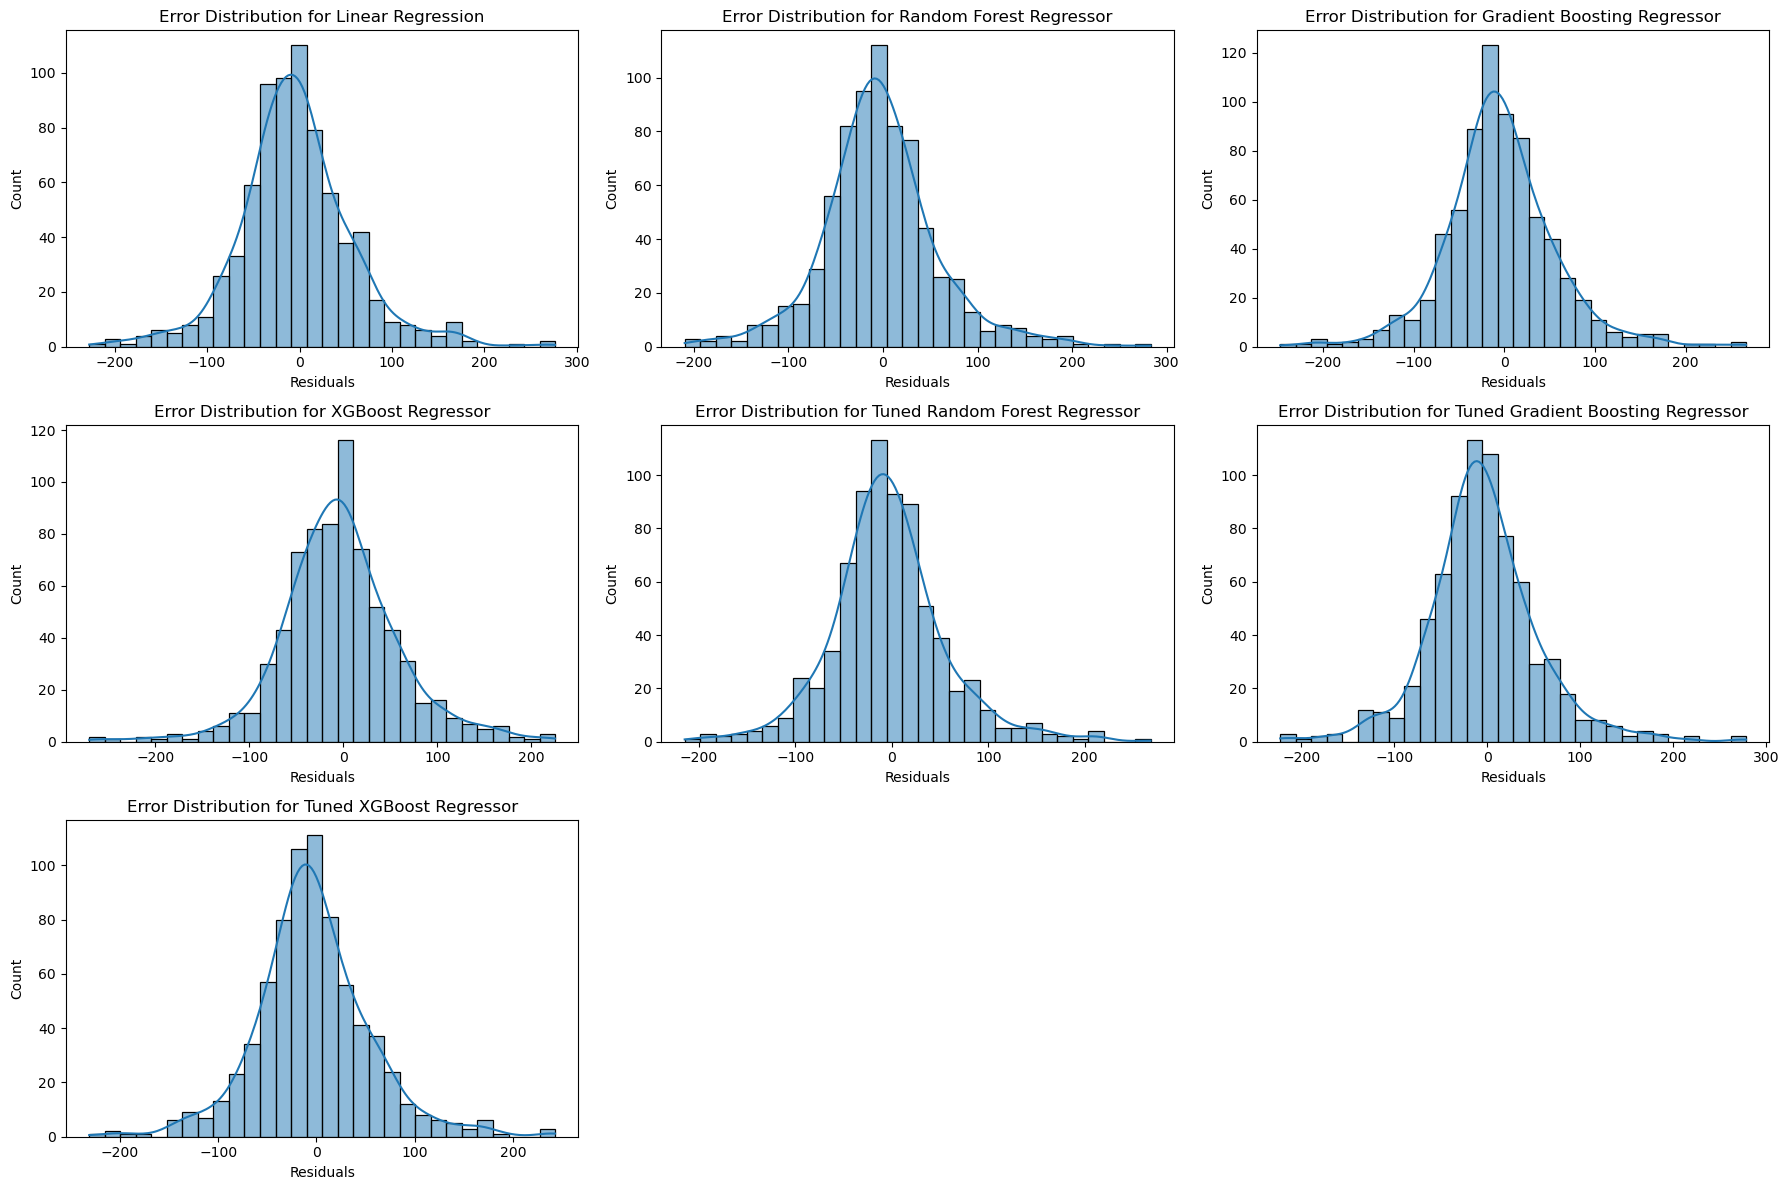

In [150]:
# Plot Error Distribution for each model
def plot_error_distribution(y_test, predictions, model_names):
    plt.figure(figsize=(18, 12))
    for i, (y_pred, model_name) in enumerate(zip(predictions, model_names)):
        residuals = y_test - y_pred
        plt.subplot(3, 3, i + 1)
        sns.histplot(residuals, kde=True, bins=30, alpha=0.5)
        plt.xlabel('Residuals')
        plt.title(f'Error Distribution for {model_name}')
    plt.tight_layout()
    plt.show()

plot_error_distribution(y_test, predictions, model_names)

# Tuned XGBoost Regressor

## Feature Importance Analysis

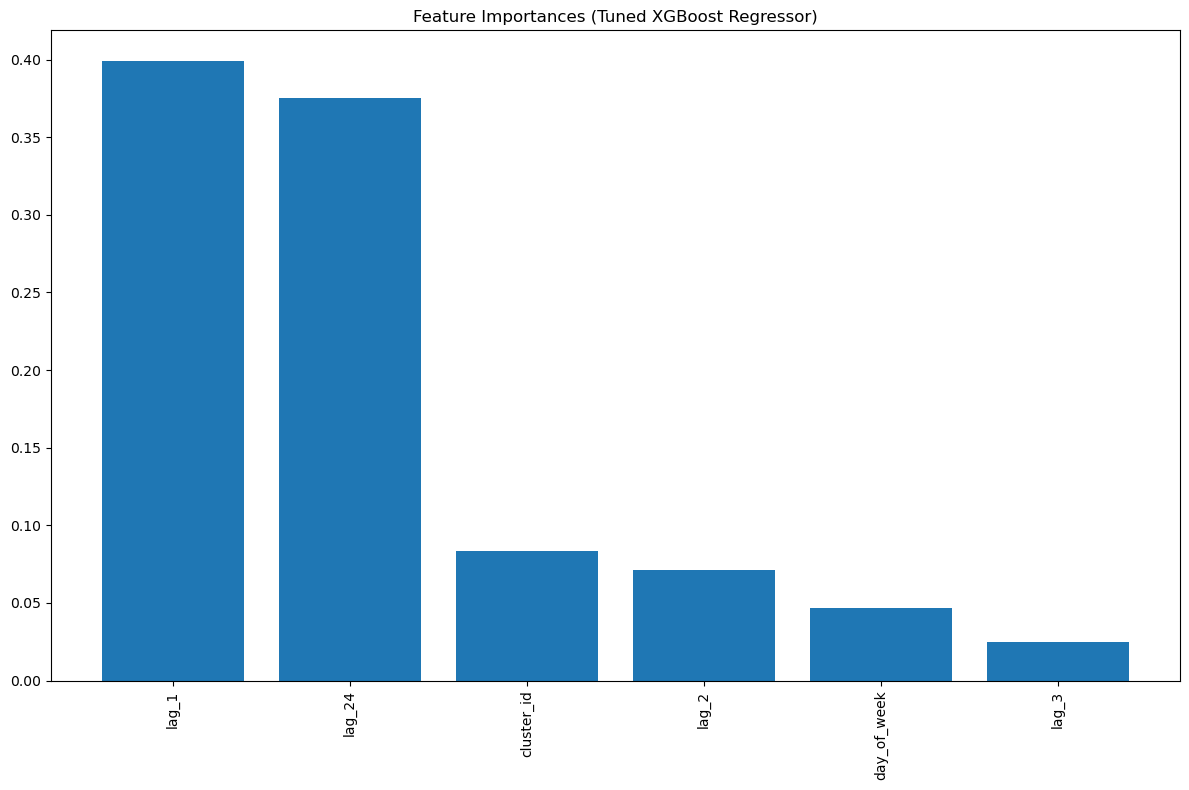

In [151]:
importances = best_xgb_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Tuned XGBoost Regressor)')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


# Save the Tuned XGBoost Model

In [152]:
# Save the tuned XGBoost model
joblib.dump(best_xgb_model, 'tuned_xgboost_model.pkl')


['tuned_xgboost_model.pkl']